In [43]:
import os
from input_reader import InputReader
from tracker import Tracker
import copy
import numpy as np
import traceback
from scipy.spatial import distance as dist
import pandas as pd
import scipy.stats as st
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import gridspec
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_auc_score

%matplotlib inline

# import utility functions

# define three constants. 
# You can later experiment with these constants by changing them to adaptive variables.
EAR_THRESHOLD = 0.21 # eye aspect ratio to indicate blink
EAR_CONSEC_FRAMES = 3 # number of consecutive frames the eye must be below the threshold
SKIP_FIRST_FRAMES = 0 # how many frames we should skip at the beggining

# initialize output structures
scores_string = ""

In [447]:
def load_datasets(path, dataset_name):
    # build  full path
    full_path = os.path.join(path, dataset_name)
    
    # read prediction results and frame_info_df
    closeness_pred, blinks_pred, frame_info_df \
                = read_outputs("{}_pred".format(full_path),"{}_frame_info_df".format(full_path))

    # read test results
    closeness_test, blinks_test = read_outputs("{}_test".format(full_path), test = True)
    
    # read scores
    with open("{}_scores.txt".format(full_path),"r") as f:
        Lines = f.readlines() 
        # build a string that hold scores
        scores_str = ""
        for line in Lines: 
            scores_str += line

    return  closeness_pred, blinks_pred, frame_info_df, closeness_test, blinks_test, scores_str

def read_outputs(h5_name, parquet_name=None, test=False):
    # read h5 file by name
    hf = h5py.File('{}.h5'.format(h5_name), 'r')
    
    # if you are reading prediction results
    if test == False:  
        g = hf.get("pred") # read group first   
        
    # if you are reading test results
    if test == True:
         g = hf.get("test") # read group first  
            
    # then get datasets
    closeness_list = list(g.get('closeness_list'))
    blink_list = list(g.get('blinks_list'))

    # if you want to read frame_df_info
    if parquet_name != None:
        frame_info_df = pd.read_parquet('{}.parquet'.format(parquet_name), engine='pyarrow')
        return closeness_list, blink_list, frame_info_df
    
    # if you don't want to read frame_df_info
    else:
        return closeness_list, blink_list

def estimate_first_n(data, start_n=50, limit_n=300, step=1, epsilon=10e-8):
    n = start_n 
    while True:
        # for first n values fit a linear regression line 
        data0 = data[:n]
        m0,b0 = np.polyfit(np.arange(n),data0, 1)
        
        # check if n + step reaches limit
        if n + step > limit_n-1:
            print("error - reached the limit")
            break

        # for first n + step values fit a linear regression line 
        data1 = data[:n+step]
        m1,b1 = np.polyfit(np.arange(n + step),data1, 1)

        # if m1-m0 converges to epsilon
        if abs(m1 - m0) < epsilon and m0 > 0:
            break
        n += step
        
    return n, m0

def display_blinks(blinks, processed_frames):    
    i=1
    # loop over blinks and determine starting, middle and ending frames
    for (frame_start,frame_end) in blinks:
        duration = frame_end - frame_start + 1
        frame_middle = frame_start + int(duration / 2)
        print("{}th blink started at: {}th frame, middle of action at: {}th frame, ended at: {}th frame".format(i,frame_start, frame_middle, frame_end))
        i+=1
        
        # show starting, middle and ending frames
        f, axarr = plt.subplots(1,3,figsize=(15,15))
        img1 = processed_frames[frame_start - 1] # -1 since index starts by 0, frame numbers starts by 1
        img2 = processed_frames[frame_middle - 1] 
        img3 = processed_frames[frame_end - 1] 
        axarr[0].imshow(img1)
        axarr[1].imshow(img2)
        axarr[2].imshow(img3)
        plt.show()
    return

def detect_outliers_iqr(input_list):
    # calculate interquartile range
    q25, q75 = np.percentile(input_list, 25), np.percentile(input_list, 75)
    iqr = q75 - q25
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

def detect_outliers_conf(input_list, confidence=0.95):
    # identify boudaries
    lower, upper  = st.t.interval(confidence, len(input_list)-1, loc=np.mean(input_list), \
                                        scale=st.sem(input_list))
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

def detect_outliers_z(input_list, z_limit=2):
    # identify boudaries
    mu = input_list.mean()
    sigma = input_list.std()
    val = z_limit * sigma
    lower  =  mu - val
    upper =  mu + val
    
    # identify outliers
    outliers = [(i, x) for (i, x) in list(enumerate(input_list)) if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # remove outliers
    clean_input_list = [x for x in input_list if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(clean_input_list))
    print("")
    
    return clean_input_list, outliers, upper, lower

def read_annotations_v2(input_file, len_video):
    # Read .tag file using readlines() 
    file1 = open(input_file) 
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # length of annotations
    len_annot = len(Lines[start_line : -1]) # -1 since last line will be"#end"
    blink_list = [0] * len_video
    closeness_list = [0] * len_video

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    f_name = []
    for i in range(len_annot): 
        f_name = os.path.basename(input_file).split('.tag')[0]
        annotation=Lines[start_line+i].split(':')

        if int(annotation[1]) > 0:
            # it means a new blink
            blink_frame = int(annotation[0])
            try:
                blink_list[blink_frame] = 1
            except:
                continue

        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if annotation[3] == "C" and annotation[5] == "C":
            closed_frame = int(annotation[0])
            closeness_list[closed_frame] = 1

        file1.close()

    result_df = pd.DataFrame(list(zip(closeness_list, blink_list)), columns=['closeness_annot', 'blink_annot'])
    result_df['f_name'] = f_name
    return result_df

def read_annotations(input_file, skip_n = 0):
    # define variables 
    blink_start = 1
    blink_end = 1
    blink_info = (0,0)
    blink_list = []
    closeness_list = []

    # Using readlines() 
    file1 = open(input_file) 
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    for index in range(len(Lines[start_line+skip_n : -1])): # -1 since last line will be"#end"
        
        # read previous annotation and current annotation 
        prev_annotation=Lines[start_line+skip_n+index-1].split(':')
        current_annotation=Lines[start_line+skip_n+index].split(':')
        
        # if previous annotation is not "#start" line and not "blink" and current annotation is a "blink"
        if prev_annotation[0] != "#start\n" and prev_annotation[1] == "-1" and int(current_annotation[1]) > 0:
            # it means a new blink starts so save frame id as starting frame of the blink
            blink_start = int(current_annotation[0])
        
        # if previous annotation is not "#start" line and is a "blink" and current annotation is not a "blink"
        if prev_annotation[0] != "#start\n" and int(prev_annotation[1]) > 0 and current_annotation[1] == "-1":
            # it means a new blink ends so save (frame id - 1) as ending frame of the blink
            blink_end = int(current_annotation[0]) - 1
            # and construct a "blink_info" tuple to append the "blink_list"
            blink_info = (blink_start,blink_end)
            blink_list.append(blink_info)
        
        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if current_annotation[3] == "C" and current_annotation[5] == "C":
            closeness_list.append(1)
        
        else:
            closeness_list.append(0)
    
    file1.close()
    return closeness_list, blink_list

def read_annotations(input_file, skip_n = 0):
    # define variables 
    blink_start = 1
    blink_end = 1
    blink_info = (0,0)
    blink_list = []
    closeness_list = []

    # Using readlines() 
    file1 = open(input_file) 
    Lines = file1.readlines() 

    # find "#start" line 
    start_line = 1
    for line in Lines: 
        clean_line=line.strip()
        if clean_line=="#start":
            break
        start_line += 1

    # convert tag file to readable format and build "closeness_list" and "blink_list"
    for index in range(len(Lines[start_line+skip_n : -1])): # -1 since last line will be"#end"
        
        # read previous annotation and current annotation 
        prev_annotation=Lines[start_line+skip_n+index-1].split(':')
        current_annotation=Lines[start_line+skip_n+index].split(':')
        
        # if previous annotation is not "#start" line and not "blink" and current annotation is a "blink"
        if prev_annotation[0] != "#start\n" and prev_annotation[1] == "-1" and int(current_annotation[1]) > 0:
            # it means a new blink starts so save frame id as starting frame of the blink
            blink_start = int(current_annotation[0])
        
        # if previous annotation is not "#start" line and is a "blink" and current annotation is not a "blink"
        if prev_annotation[0] != "#start\n" and int(prev_annotation[1]) > 0 and current_annotation[1] == "-1":
            # it means a new blink ends so save (frame id - 1) as ending frame of the blink
            blink_end = int(current_annotation[0]) - 1
            # and construct a "blink_info" tuple to append the "blink_list"
            blink_info = (blink_start,blink_end)
            blink_list.append(blink_info)
        
        # if current annotation consist fully closed eyes, append it also to "closeness_list" 
        if current_annotation[3] == "C" and current_annotation[5] == "C":
            closeness_list.append(1)
        
        else:
            closeness_list.append(0)
    
    file1.close()
    return closeness_list, blink_list

def display_test_scores(closeness_list_test, closeness_list_pred):
    str_out = ""
    str_out += ("EYE CLOSENESS FRAME BY FRAME TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(closeness_list_test, closeness_list_pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(closeness_list_test, closeness_list_pred)
    str_out += ("AUC: {:.4f}\n".format(auc))
    str_out += ("\n")

    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(closeness_list_test, closeness_list_pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(closeness_list_test, closeness_list_pred)))
    
#     print(str_out)
    return str_out

def display_stats(closeness_list, blinks_list, video_info = None, skip_n = 0, test = False):
    str_out = ""
    # write video info
    if video_info != None:
        str_out += ("Video info\n")
        str_out += ("FPS: {}\n".format(video_info["fps"]))
        str_out += ("FRAME_COUNT: {}\n".format(video_info["frame_count"]))
        str_out += ("DURATION (s): {:.2f}\n".format(video_info["duration(s)"]))
        str_out += ("\n")
    
    # if you skipped n frames previously
    if skip_n > 0:
        str_out += ("After skipping {} frames,\n".format(skip_n))   
        
    # if you are displaying prediction information
    if test == False:    
        str_out += ("Statistics on the prediction set are\n")
    
    # if you are displaying test information
    if test == True:    
        str_out += ("Statistics on the test set are\n")
    
    str_out += ("TOTAL NUMBER OF FRAMES PROCESSED: {}\n".format(len(closeness_list)))
    str_out += ("NUMBER OF CLOSED FRAMES: {}\n".format(closeness_list.count(1)))
    if test == True:
        str_out += ("NUMBER OF BLINKS: {}\n".format(len(blinks_list)))
    else:
        str_out += ("NUMBER OF BLINKS: {}\n".format(blinks_list))
    str_out += ("\n")
    
    return str_out

In [79]:
#define path and dataset_name
path = "C:\\Users\\huynh14\\DMS\\scripts\\facelandmarks\\OpenSeeFace"
dataset_name = "talking"

# load datasets
c_pred, b_pred, df, c_test, b_test, s_str = load_datasets(path, dataset_name)

# check results
print(np.array(c_pred).shape, np.array(b_pred).shape)
print(np.array(c_test).shape, np.array(b_test).shape)
print()

#display statistics
print(s_str)

#display the first rows of data frame
df[:3]

(5000,) (59, 2)
(5000,) (61, 2)

Processing talking.avi has done.

Video info
FPS: 30.0
FRAME_COUNT: 5000
DURATION (s): 166.67

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 384
NUMBER OF BLINKS: 59

Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 153
NUMBER OF BLINKS: 61

EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9538

AUC: 0.9762

CONFUSION MATRIX:
[[4616  231]
 [   0  153]]

FALSE POSITIVES:
0 out of 153 positive labels (0.0000%)

FALSE NEGATIVES:
231 out of 4847 negative labels (0.0477%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98      4847
           1       0.40      1.00      0.57       153

    accuracy                           0.95      5000
   macro avg       0.70      0.98      0.77      5000
weighted avg       0.98      0.95      0.96      5000



,frame_no,face_detected,face_coordinates,left_eye_coor,right_eye_coor,left_ear,right_ear,avg_ear,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration
0,1,1,0,0,0,0.260642,0.264124,0.262383,0,0,0,0,False
1,2,1,0,0,0,0.266113,0.266794,0.266454,0,0,0,0,False
2,3,1,0,0,0,0.276074,0.266118,0.271096,0,0,0,0,False


SLOPE = 0.00000


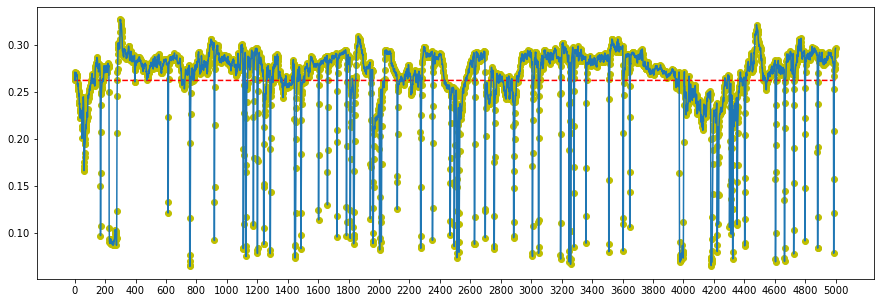

In [82]:
data = np.array(df['avg_ear'])
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(data)+1, 200))
m,b = np.polyfit(np.arange(len(data)),data, 1)
print("SLOPE = {:.5f}".format(m))
plt.plot(np.arange(len(data)),data,'yo', np.arange(len(data)), m*np.arange(len(data))+b, '--r')
plt.plot(data);

SCOPE = -0.00045


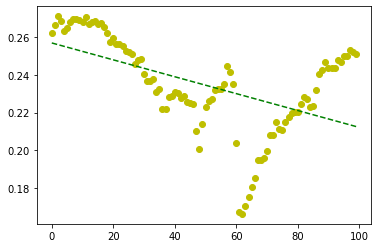

In [83]:
n = 100
data100 = data[:n]
m,b = np.polyfit(np.arange(n),data100, 1)
print("SCOPE = {:.5f}".format(m))
plt.plot(np.arange(n),data100,'yo', np.arange(n), m*np.arange(n)+b, '--g');

error - reached the limit
n = 50.00000
m = -0.00126


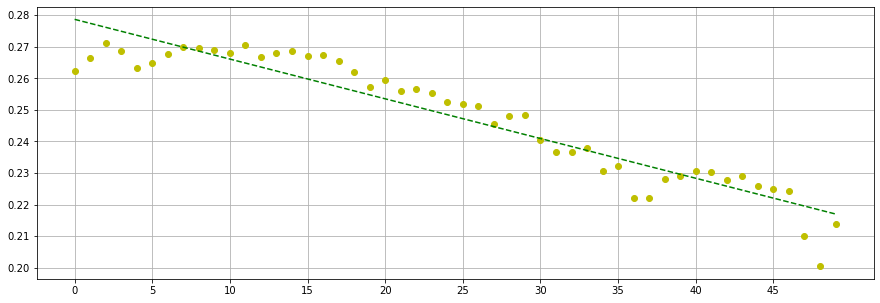

In [114]:
# calculate a limit_n for 10 secs with using fps of the video
fps = int(s_str[49:51])
limit_secs = 10
limit_frame = limit_secs * fps

# run the function above
n,m0 = estimate_first_n(data, limit_n=limit_frame)

# get first n frames and plot it with linear regression
calibration = data[:n]
m,b = np.polyfit(np.arange(n), calibration, 1)
linear = m*np.arange(n)+b
print("n = {:.5f}".format(n))
print("m = {:.5f}".format(m))
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(np.arange(n),calibration,'yo', np.arange(n), linear, '--g');

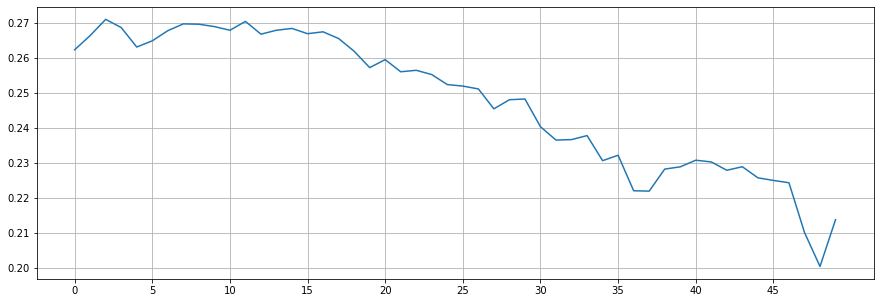

In [87]:
blink1 = calibration[:163]
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(blink1), 5))
plt.grid()
plt.plot(blink1);

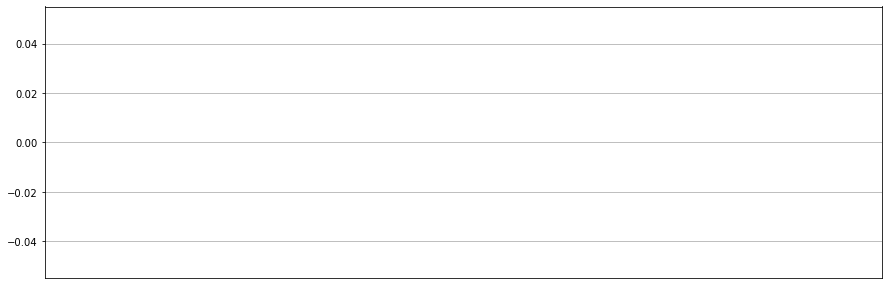

In [88]:
# plot data between 138 - 218
blink2 = calibration[138:]
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, len(blink2), 2),np.arange(138, 138+len(blink2),2))
plt.grid()
plt.plot(blink2);

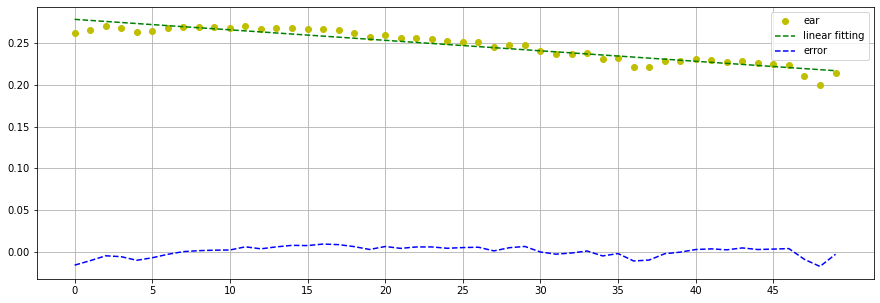

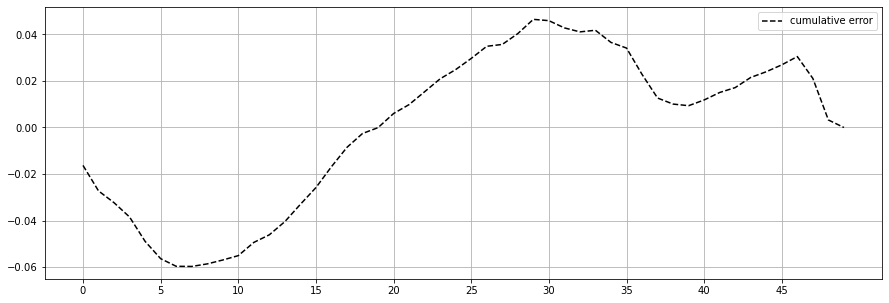

In [93]:
errors = calibration - linear

# plot errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(calibration,'yo', linear, '--g', errors, '--b')
plt.legend(labels = ['ear', 'linear fitting', 'error'])
plt.show()

# cumulative errors
cum_errors = errors.cumsum()

# plot cumulative errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(np.arange(n), cum_errors, '--k')
plt.legend(labels = ['cumulative error'])
plt.show();

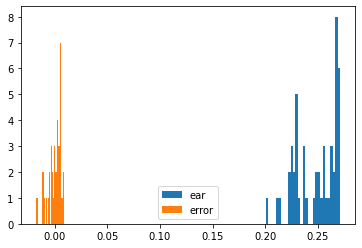

In [94]:
plt.hist(calibration, bins=30)
plt.hist(errors, bins=30)
plt.legend(['ear', 'error']);

In [100]:
outliers_c

[]

In [115]:
calibration

array([0.262383  , 0.26645356, 0.27109566, 0.26875359, 0.26318326,
       0.26495397, 0.26785227, 0.26980165, 0.26970572, 0.26902899,
       0.26797628, 0.27051469, 0.26685732, 0.26798968, 0.26849888,
       0.26699576, 0.26752909, 0.2656109 , 0.26197739, 0.25729379,
       0.25958073, 0.25610536, 0.25652758, 0.25530046, 0.25244359,
       0.25201063, 0.25119763, 0.24550371, 0.24811221, 0.24831998,
       0.24037971, 0.23657349, 0.23670713, 0.23785342, 0.23067972,
       0.23223085, 0.22208018, 0.2219708 , 0.22827391, 0.22892229,
       0.23081434, 0.23031891, 0.22794301, 0.22895057, 0.22577559,
       0.22503414, 0.22437091, 0.21016586, 0.20043484, 0.21380209])

In [101]:
# run detect_outliers_iqr() on errors
_, outliers, upper, lower =  detect_outliers_iqr(errors)
outlier_indexes = list(zip(*outliers))[0]
outlier_values = list(zip(*outliers))[1]

# run detect_outliers_iqr() on calibration
_, outliers_c, upper_c, lower_c =  detect_outliers_iqr(calibration)
outlier_indexes_c = list(zip(*outliers_c))[0]
outlier_values_c = list(zip(*outliers_c))[1]

Percentiles: 25th=-0.003, 75th=0.005, IQR=0.008
Identified outliers: 2
Non-outlier observations: 48

Percentiles: 25th=0.230, 75th=0.267, IQR=0.036
Identified outliers: 0
Non-outlier observations: 50



IndexError: list index out of range

In [117]:
# run detect_outliers_conf() for 0.99 on errors
_, _, _, lower_conf = detect_outliers_conf(errors, 0.99)

# run detect_outliers_conf() for 0.99 on calibration
_, _, _, lower_conf_c = detect_outliers_conf(calibration, 0.99)

Identified outliers: 39
Non-outlier observations: 11

Identified outliers: 44
Non-outlier observations: 6



In [120]:
#z-scores
# run detect_outliers_z() for z_limit=2 on errors
_, outliers_z, _, lower_z = detect_outliers_z(errors, 2)
outlier_indexes_z = list(zip(*outliers_z))[0]
outlier_values_z = list(zip(*outliers_z))[1]

# run detect_outliers_z() for z_limit=2 on calibration
_, outliers_z_c, _, lower_z_c = detect_outliers_z(calibration, 2)
outlier_indexes_z_c = list(zip(*outliers_z_c))[0]
outlier_values_z_c = list(zip(*outliers_z_c))[1]

Identified outliers: 2
Non-outlier observations: 48

Identified outliers: 1
Non-outlier observations: 49



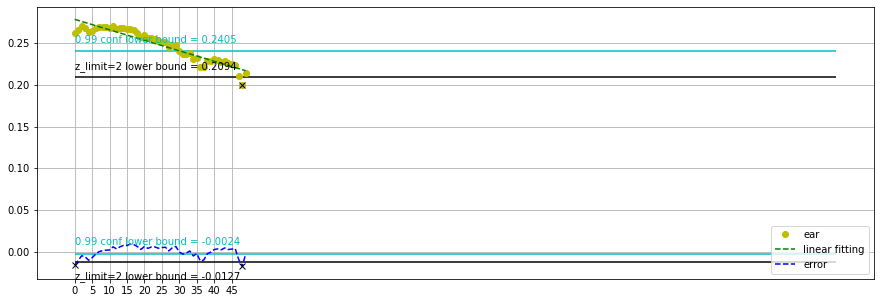

In [122]:
# plot calibration and errors
plt.figure(figsize=(15,5))
plt.xticks(np.arange(0, n, 5))
plt.grid()
plt.plot(calibration,'yo', linear, '--g', errors, '--b')
plt.legend(labels = ['ear', 'linear fitting', 'error'], loc='lower right')

# # plot outliers for errors
# plt.plot(outlier_indexes, outlier_values, 'ro')
# plt.hlines(lower, 0, 218, colors='r', linestyles='-')
# plt.text(0, lower + 0.01, 'iqr lower bound = {:.4f}'.format(lower), color='r')

# # # plot outliers for calibration
# # plt.plot(outlier_indexes_c, outlier_values_c, 'ro')
# # plt.hlines(lower_c, 0, 218, colors='r', linestyles='-')
# # plt.text(0, lower_c - 0.02, 'iqr lower bound = {:.4f}'.format(lower_c), color='r')

# 99% confidence for errors
plt.hlines(lower_conf, 0, 218, colors='c', linestyles='-')
plt.text(0, lower_conf + 0.01, '0.99 conf lower bound = {:.4f}'.format(lower_conf), color='c')

# 99% confidence for calibration
plt.hlines(lower_conf_c, 0, 218, colors='c', linestyles='-')
plt.text(0, lower_conf_c + 0.01, '0.99 conf lower bound = {:.4f}'.format(lower_conf_c), color='c')

# z_limit=2 for errors
plt.plot(outlier_indexes_z, outlier_values_z, 'kx')
plt.hlines(lower_z, 0, 218, colors='k', linestyles='-')
plt.text(0, lower_z - 0.02, 'z_limit=2 lower bound = {:.4f}'.format(lower_z), color='k')

# z_limit=2 for calibration
plt.plot(outlier_indexes_z_c, outlier_values_z_c, 'kx')
plt.hlines(lower_z_c, 0, 218, colors='k', linestyles='-')
plt.text(0, lower_z_c + 0.01, 'z_limit=2 lower bound = {:.4f}'.format(lower_z_c), color='k')
plt.show()

# SVM

In [310]:
from imutils import paths
import glob

In [343]:
avi_video_files = []
tag_video_files = []
for i in list(paths.list_files('.\\eye_blink')):
    if i.endswith('.avi'):
        avi_video_files.append(i)
    elif i.endswith('.tag'):
        tag_video_files.append(i)

In [344]:
csv_file = list(paths.list_files('.\\csv\\eye_blink'))

In [345]:
tag_df = pd.DataFrame()
for tag_video in tag_video_files:
    temp_df = pd.DataFrame()
    for j in csv_file:
        if os.path.basename(j).split('_cam')[0] in tag_video:
            read_path = j
            break
    temp_df = pd.read_csv(read_path)
    temp_df = temp_df.drop(temp_df.columns[0], axis=1)
    df = read_annotations_v2(tag_video, len(temp_df))
    tag_df = pd.concat((tag_df, df))

15711
9014
4890
11123
9216
5315
10663
5060
5000


In [319]:
csv_df = pd.DataFrame()
for csv in csv_file:
    csv_name = os.path.basename(csv).split('.avi')[0]
    temp_df = pd.read_csv(csv)
    temp_df2 = tag_df[tag_df['f_name'] == csv_name]
    temp_df3 = pd.concat((temp_df, temp_df2), axis=1)
    csv_df = pd.concat((csv_df, temp_df3))

In [494]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [495]:
df = df.reset_index()

In [496]:
df.drop('index', axis=1)

,frame_no,face_detected,face_coordinates,left_eye_coor,right_eye_coor,left_ear,right_ear,avg_ear,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration,closeness_annot,blink_annot,subject
0,1,1,0,0,0,0.173757,0.163599,0.168678,1,0,0,0,False,0,0,0
1,2,1,0,0,0,0.142890,0.147016,0.144953,1,0,0,0,False,0,0,0
2,3,1,0,0,0,0.088263,0.102932,0.095598,1,0,0,0,False,0,0,0
3,4,1,0,0,0,0.064955,0.084438,0.074696,1,0,0,0,False,0,0,0
4,5,1,0,0,0,0.183811,0.111614,0.147713,1,0,0,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76131,4996,1,0,0,0,0.292738,0.267288,0.280013,0,54,4987,4989,False,0,0,8
76132,4997,1,0,0,0,0.296478,0.267973,0.282226,0,54,4987,4989,False,0,0,8
76133,4998,1,0,0,0,0.296699,0.263573,0.280136,0,54,4987,4989,False,0,0,8
76134,4999,1,0,0,0,0.295883,0.266669,0.281276,0,54,4987,4989,False,0,0,8


In [497]:
df.dropna(inplace=True)

In [498]:
df

,index,frame_no,face_detected,face_coordinates,left_eye_coor,right_eye_coor,left_ear,right_ear,avg_ear,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration,closeness_annot,blink_annot,subject
0,0,1,1,0,0,0,0.173757,0.163599,0.168678,1,0,0,0,False,0,0,0
1,1,2,1,0,0,0,0.142890,0.147016,0.144953,1,0,0,0,False,0,0,0
2,2,3,1,0,0,0,0.088263,0.102932,0.095598,1,0,0,0,False,0,0,0
3,3,4,1,0,0,0,0.064955,0.084438,0.074696,1,0,0,0,False,0,0,0
4,4,5,1,0,0,0,0.183811,0.111614,0.147713,1,0,0,0,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76131,4995,4996,1,0,0,0,0.292738,0.267288,0.280013,0,54,4987,4989,False,0,0,8
76132,4996,4997,1,0,0,0,0.296478,0.267973,0.282226,0,54,4987,4989,False,0,0,8
76133,4997,4998,1,0,0,0,0.296699,0.263573,0.280136,0,54,4987,4989,False,0,0,8
76134,4998,4999,1,0,0,0,0.295883,0.266669,0.281276,0,54,4987,4989,False,0,0,8


In [499]:
data = df[['frame_no', 'avg_ear', 'blink_annot', 'subject']]

In [500]:
user_list = list(data['subject'].unique())
list_of_dfs=[]
for user in user_list:
    list_of_dfs.append(data.groupby('subject').get_group(user))

In [501]:
list_of_13dfs = []
for subject_df in list_of_dfs:
    for i in range(-6,7):
        subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear']
    subject_df=subject_df[6:-6]
    list_of_13dfs.append(subject_df)
    
# concat results
ear13_df = pd.concat(list_of_13dfs)
ear13_df.drop(columns=['frame_no', 'avg_ear'],inplace=True)
ear13_df.reset_index(drop=True, inplace=True)

<ipython-input-501-5fa3c562ddb3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear']


In [502]:
print(ear13_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76028 entries, 0 to 76027
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   blink_annot  76028 non-null  int64  
 1   subject      76028 non-null  int64  
 2   ear-6        76028 non-null  float64
 3   ear-5        76028 non-null  float64
 4   ear-4        76028 non-null  float64
 5   ear-3        76028 non-null  float64
 6   ear-2        76028 non-null  float64
 7   ear-1        76028 non-null  float64
 8   ear0         76028 non-null  float64
 9   ear1         76028 non-null  float64
 10  ear2         76028 non-null  float64
 11  ear3         76028 non-null  float64
 12  ear4         76028 non-null  float64
 13  ear5         76028 non-null  float64
 14  ear6         76028 non-null  float64
dtypes: float64(13), int64(2)
memory usage: 8.7 MB
None


TOTAL COUNT: 76028
POSITIVE COUNT: 4135
NEGATIVE COUNT: 71893



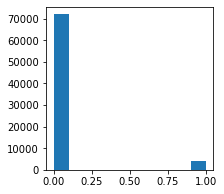

In [503]:
plt.figure(figsize =(3,3))
plt.hist(ear13_df.blink_annot)
total_count = len(ear13_df)
pos_count = ear13_df.loc[ear13_df['blink_annot'] == 1, 'blink_annot'].count()
neg_count = ear13_df.loc[ear13_df['blink_annot'] == 0, 'blink_annot'].count()
print("TOTAL COUNT: {}\nPOSITIVE COUNT: {}\nNEGATIVE COUNT: {}\n".format(total_count,pos_count,neg_count))

In [562]:
ear13_df.to_csv('data_v2_model.csv')

In [563]:
ear13_df

,subject,blink_annot,ear-6,ear-5,ear-4,ear-3,ear-2,ear-1,ear0,ear1,ear2,ear3,ear4,ear5,ear6
0,0,0,1.000000,1.000000,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986
1,0,0,1.000000,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571
2,0,0,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338
3,0,0,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338,1.000000
4,0,0,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76023,8,1,0.998699,1.000000,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346
76024,8,1,1.000000,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895
76025,8,1,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895,0.996899
76026,8,0,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895,0.996899,0.995639


# Load data

In [548]:
gt = read_annotations_v2('eye_blink/eyeblink8/9/27122013_152435_cam.tag', 5000)
gt

,closeness_annot,blink_annot,f_name
0,0,0,27122013_152435_cam
1,0,0,27122013_152435_cam
2,0,0,27122013_152435_cam
3,0,0,27122013_152435_cam
4,0,0,27122013_152435_cam
...,...,...,...
4995,0,0,27122013_152435_cam
4996,0,0,27122013_152435_cam
4997,0,0,27122013_152435_cam
4998,0,1,27122013_152435_cam


In [578]:
data = pd.read_csv('./data_training/26122013_230654_cam.avi.csv')

In [579]:
data

,Unnamed: 0,frame_no,face_detected,face_coordinates,left_eye_coor,right_eye_coor,left_ear,right_ear,avg_ear,avg_ear_model,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration,output_closeness
0,0,1,1,0,0,0,0.167051,0.163016,0.165034,1.000000,0,0,0,0,False,0
1,1,2,1,0,0,0,0.197252,0.156421,0.176837,1.000000,0,0,0,0,False,0
2,2,3,1,0,0,0,0.227134,0.171944,0.199539,1.000000,0,0,0,0,False,0
3,3,4,1,0,0,0,0.189872,0.169790,0.179831,1.000000,0,0,0,0,False,0
4,4,5,1,0,0,0,0.192235,0.160348,0.176291,1.000000,0,0,0,0,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5346,5346,5347,1,0,0,0,0.224584,0.188819,0.206702,0.609108,0,13,5333,5338,False,0
5347,5347,5348,1,0,0,0,0.213742,0.192958,0.203350,0.591557,0,13,5333,5338,False,0
5348,5348,5349,1,0,0,0,0.220602,0.195931,0.208266,0.609983,0,13,5333,5338,False,0
5349,5349,5350,1,0,0,0,0.210857,0.192523,0.201690,0.581933,0,13,5333,5338,False,0


In [555]:
csv_file = ['.\\data_training\\27122013_153916_cam.avi.csv',
            '.\\data_training\\26122013_224532_cam.avi.csv',
            '.\\data_training\\26122013_223310_cam.avi.csv',
            '.\\data_training\\27122013_154548_cam.avi.csv',
             '.\\data_training\\26122013_230103_cam.avi.csv',
             '.\\data_training\\26122013_230654_cam.avi.csv',
             '.\\data_training\\27122013_151644_cam.avi.csv',
             '.\\data_training\\27122013_152435_cam.avi.csv',
             '.\\data_training\\talking.avi.csv']

In [568]:
df = pd.DataFrame()
for index, csv in enumerate(csv_file):
    name = os.path.basename(csv).split('.avi')[0]
    temp_df = pd.read_csv(csv)
    for i in tag_video_files:
        if name in i:
            match_name = i
            break
    print(name, '-', match_name, '-', index)
    tag_df = read_annotations_v2(match_name, len(temp_df))
    temp_df['closeness_annot'] = tag_df['closeness_annot']
    temp_df['blink_annot'] = tag_df['blink_annot']
    temp_df['subject'] = index
    df = pd.concat((df, temp_df))

27122013_153916_cam - .\eye_blink\eyeblink8\10\27122013_153916_cam.tag - 0
26122013_224532_cam - .\eye_blink\eyeblink8\2\26122013_224532_cam.tag - 1
26122013_223310_cam - .\eye_blink\eyeblink8\1\26122013_223310_cam.tag - 2
27122013_154548_cam - .\eye_blink\eyeblink8\11\27122013_154548_cam.tag - 3
26122013_230103_cam - .\eye_blink\eyeblink8\3\26122013_230103_cam.tag - 4
26122013_230654_cam - .\eye_blink\eyeblink8\4\26122013_230654_cam.tag - 5
27122013_151644_cam - .\eye_blink\eyeblink8\8\27122013_151644_cam.tag - 6
27122013_152435_cam - .\eye_blink\eyeblink8\9\27122013_152435_cam.tag - 7
talking - .\eye_blink\talkingFace\talking.tag - 8


In [557]:
df

,Unnamed: 0,frame_no,face_detected,face_coordinates,left_eye_coor,right_eye_coor,left_ear,right_ear,avg_ear,avg_ear_model,closeness,blink_no,blink_start_frame,blink_end_frame,reserved_for_calibration,output_closeness,closeness_annot,blink_annot,subject
0,0,1,1,0,0,0,0.173757,0.163599,0.168678,1.000000,0,0,0,0,False,0,0,0,0
1,1,2,1,0,0,0,0.142890,0.147016,0.144953,1.000000,0,0,0,0,False,0,0,0,0
2,2,3,1,0,0,0,0.088263,0.102932,0.095598,0.200000,1,0,0,0,False,1,0,0,0
3,3,4,1,0,0,0,0.064955,0.084438,0.074696,0.440000,1,0,0,0,False,1,0,0,0
4,4,5,1,0,0,0,0.183811,0.111614,0.147713,0.984000,0,0,0,0,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,4996,1,0,0,0,0.292738,0.267288,0.280013,0.986346,0,60,4987,4990,False,0,0,0,8
4996,4996,4997,1,0,0,0,0.296478,0.267973,0.282226,0.991895,0,60,4987,4990,False,0,0,0,8
4997,4997,4998,1,0,0,0,0.296699,0.263573,0.280136,0.996899,0,60,4987,4990,False,0,0,0,8
4998,4998,4999,1,0,0,0,0.295883,0.266669,0.281276,0.995639,0,60,4987,4990,False,0,0,0,8


In [561]:
ear = df[['subject','frame_no','avg_ear_model','blink_annot']]

# group by subject
user_list = list(ear['subject'].unique())
list_of_dfs=[]
for user in user_list:
    list_of_dfs.append(ear.groupby('subject').get_group(user))


# construct a df with columns depicting 13 frame window (6 previous frames + current frame + 6 next frames)
list_of_13dfs = []
for subject_df in list_of_dfs:
    for i in range(-6,7):
        subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear_model']
    subject_df=subject_df[6:-6]
    list_of_13dfs.append(subject_df)
    
# concat results
ear13_df = pd.concat(list_of_13dfs)
ear13_df.drop(columns=['frame_no', 'avg_ear_model'],inplace=True)
ear13_df.reset_index(drop=True, inplace=True)
ear13_df

<ipython-input-561-abf8e1138542>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['ear'+str(i)] = subject_df.shift(periods=i*(-1))['avg_ear_model']


,subject,blink_annot,ear-6,ear-5,ear-4,ear-3,ear-2,ear-1,ear0,ear1,ear2,ear3,ear4,ear5,ear6
0,0,0,1.000000,1.000000,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986
1,0,0,1.000000,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571
2,0,0,0.200000,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338
3,0,0,0.440000,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338,1.000000
4,0,0,0.984000,1.000000,1.000000,1.000000,1.000000,1.000000,0.991750,0.585284,0.469986,0.617571,0.933338,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76023,8,1,0.998699,1.000000,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346
76024,8,1,1.000000,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895
76025,8,1,1.000000,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895,0.996899
76026,8,0,0.646861,0.289037,0.355670,0.641777,0.872047,0.956167,0.963811,0.969910,0.982186,0.986346,0.991895,0.996899,0.995639


### Display scores

In [462]:
df_talking = pd.read_csv('data.csv')

In [448]:
print(display_stats(df_talking['output_closeness'].tolist(), max(df_talking['blink_no']), skip_n=SKIP_FIRST_FRAMES))

Statistics on the prediction set are
TOTAL NUMBER OF FRAMES PROCESSED: 5000
NUMBER OF CLOSED FRAMES: 332
NUMBER OF BLINKS: 54




In [576]:
a, b = read_annotations('./eye_blink/eyeblink8/9/27122013_152435_cam.tag')

In [577]:
print(display_stats(a, b, skip_n=SKIP_FIRST_FRAMES, test=True))

Statistics on the test set are
TOTAL NUMBER OF FRAMES PROCESSED: 5060
NUMBER OF CLOSED FRAMES: 249
NUMBER OF BLINKS: 41




In [440]:
print(display_test_scores(a, df_talking['output_closeness']))

EYE CLOSENESS FRAME BY FRAME TEST SCORES

ACCURACY: 0.9642

AUC: 0.9815

CONFUSION MATRIX:
[[4668  179]
 [   0  153]]

FALSE POSITIVES:
0 out of 153 positive labels (0.0000%)

FALSE NEGATIVES:
179 out of 4847 negative labels (0.0369%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4847
           1       0.46      1.00      0.63       153

    accuracy                           0.96      5000
   macro avg       0.73      0.98      0.81      5000
weighted avg       0.98      0.96      0.97      5000



In [ ]:
##TODO: merge with frame number